<a href="https://colab.research.google.com/github/BryanBM8/SentimentAnalysis-MBTIClassification/blob/main/RM_MBTIClassification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install --upgrade pandas
!pip install accelerate -U
!pip install transformers[torch]

In [ ]:
import os
import pandas as pd
import numpy as np
import csv
import datasets
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import seaborn as sns
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import load_metric, load_dataset
from sklearn.metrics import f1_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Twitter_MBTI_Dataset/twitter_MBTI.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(10)



Mounted at /content/drive


,text,label
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj
5,Frances Farmer Will Have Her Revenge On Seattl...,intj
6,🤣🤭🤣🤭🤣🤭🤣🤭 https://t.co/2a0tICP1yk|||Blind faith...,intj
7,proud of this one it goes hard https://t.co/RQ...,intj
8,@Ieokuras so amazing!|||@hxhrats @ETTUKILLUG w...,intj
9,@JadMitri Good luck Jad!|||@ElsaYaghi A lawyer...,intj


In [ ]:
df.shape


(7811, 2)

In [ ]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


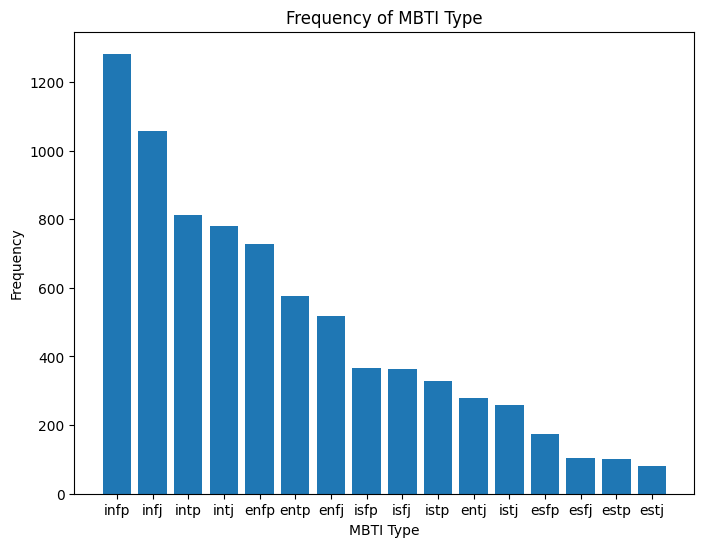

In [ ]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('MBTI Type')
plt.ylabel('Frequency')
plt.title('Frequency of MBTI Type')
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


X = df[['text']]
y = df['label']


target_size = 800
label_counts = y.value_counts()


oversample_strategy = {label: target_size for label, count in label_counts.items() if count < target_size}

undersample_strategy = {label: target_size for label, count in label_counts.items() if count > target_size}


over_sampler = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=22)
under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=22)


X_over, y_over = over_sampler.fit_resample(X, y)


X_balanced, y_balanced = under_sampler.fit_resample(X_over, y_over)




In [ ]:
balanced_df = pd.DataFrame({
    'text': np.ravel(X_balanced),
    'label': y_balanced
})


print(balanced_df)

                                                    text label
0      https://t.co/FulnLrtflg|||Big shout out to our...  enfj
1      I apologize in advance for the person I'll bec...  enfj
2      @teaalovesnana You’re welcome🥰!|||@Jtaegikook2...  enfj
3      @zakiscorner Hahaha the hot take conveniently ...  enfj
4      @fearIessphoenix I like the other one better||...  enfj
...                                                  ...   ...
12795  @innitsprime @glaive 🤭|||@glaiv4 its pride mon...  istp
12796  MEOWWWWW https://t.co/pLQV4aae6K|||????? https...  istp
12797  10/10 still cuz she just like me fr https://t....  istp
12798  I’m a freelance writer, but I don’t really lik...  istp
12799  @cecefan7 https://t.co/hMTYXDGWJJ|||https://t....  istp

[12800 rows x 2 columns]


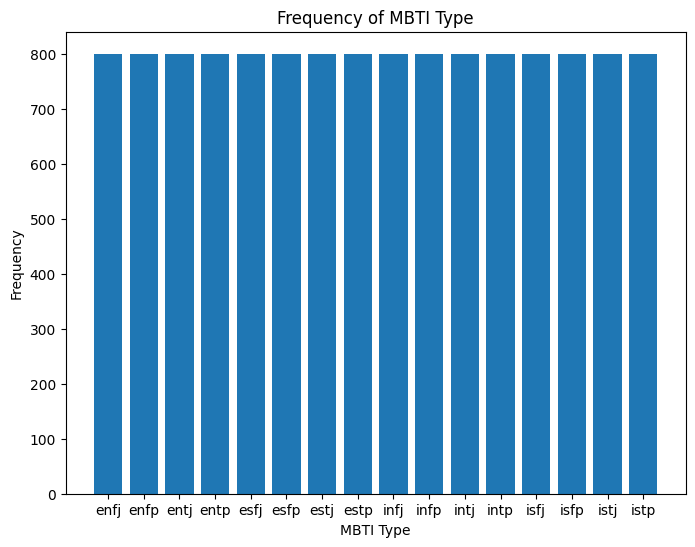

In [ ]:
label_counts = balanced_df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('MBTI Type')
plt.ylabel('Frequency')
plt.title('Frequency of MBTI Type')
plt.show()

In [ ]:
mbti_labels = {
    'infj': 0, 'infp': 1, 'intj': 2, 'intp': 3,
    'isfj': 4, 'isfp': 5, 'istj': 6, 'istp': 7,
    'enfj': 8, 'enfp': 9, 'entj': 10, 'entp': 11,
    'esfj': 12, 'esfp': 13, 'estj': 14, 'estp': 15
}

def transform_label(data):
  label = data['label'].lower()
  num = mbti_labels[label]
  return num

balanced_df['label'] = balanced_df.apply(transform_label, axis=1)

print(balanced_df['label'])

0        8
1        8
2        8
3        8
4        8
        ..
12795    7
12796    7
12797    7
12798    7
12799    7
Name: label, Length: 12800, dtype: int64


In [ ]:
print(balanced_df['text'])



0        https://t.co/FulnLrtflg|||Big shout out to our...
1        I apologize in advance for the person I'll bec...
2        @teaalovesnana You’re welcome🥰!|||@Jtaegikook2...
3        @zakiscorner Hahaha the hot take conveniently ...
4        @fearIessphoenix I like the other one better||...
                               ...                        
12795    @innitsprime @glaive 🤭|||@glaiv4 its pride mon...
12796    MEOWWWWW https://t.co/pLQV4aae6K|||????? https...
12797    10/10 still cuz she just like me fr https://t....
12798    I’m a freelance writer, but I don’t really lik...
12799    @cecefan7 https://t.co/hMTYXDGWJJ|||https://t....
Name: text, Length: 12800, dtype: object


In [ ]:
def combine_tweets(text):
    return text.replace('|||', ' ')

In [ ]:
balanced_df['text'] = balanced_df['text'].apply(combine_tweets)
print(balanced_df['text'])

0        https://t.co/FulnLrtflg Big shout out to our d...
1        I apologize in advance for the person I'll bec...
2        @teaalovesnana You’re welcome🥰! @Jtaegikook2 Y...
3        @zakiscorner Hahaha the hot take conveniently ...
4        @fearIessphoenix I like the other one better @...
                               ...                        
12795    @innitsprime @glaive 🤭 @glaiv4 its pride month...
12796    MEOWWWWW https://t.co/pLQV4aae6K ????? https:/...
12797    10/10 still cuz she just like me fr https://t....
12798    I’m a freelance writer, but I don’t really lik...
12799    @cecefan7 https://t.co/hMTYXDGWJJ https://t.co...
Name: text, Length: 12800, dtype: object


In [ ]:
#Removes links, tags (@username), emojis, punctuation
def preprocess(text):
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'\bhttps\S+\b', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

balanced_df['text'] = balanced_df['text'].apply(preprocess)
print(balanced_df['text'])

0        Big shout out to our dearest MC and PR the liv...
1        I apologize in advance for the person Ill beco...
2        Youre welcome Yes we will for sure Same Jazz I...
3        Hahaha the hot take conveniently forgets there...
4        I like the other one better Yes Boris wont kno...
                               ...                        
12795    its pride month tho JUST COME TO INDIANA SO U ...
12796    MEOWWWWW yumm TWO HOURS AGO RIGJTHTKEKSDN i wi...
12797    1010 still cuz she just like me fr oml this is...
12798    Im a freelance writer but I dont really like t...
12799    fuck no LMFAO AH he was talking abt u show you...
Name: text, Length: 12800, dtype: object


In [ ]:
train, eval = train_test_split(balanced_df,train_size=0.9,stratify=balanced_df['label'], random_state = 42)

print(train)
print(eval)

                                                    text  label
2016   please god dont tell me you think Im being ser...     10
5722   FUCK STRANGER THINGS MAN so jealous my mom is ...     15
386    Imma need to know what Raw episode this is im ...      8
10545  PEOPLE CAME BACK TO SCHOOL RAYA CELEBRATION RA...      5
931    Celebrities always get special treatment Serio...      9
...                                                  ...    ...
1236   Bori was lowkey judging me for not petting Kev...      9
3864   This deserved a full track TT whyyyy but still...     12
6841   you look amazing WAT ZEG JE OMG my itziar obse...      0
800    no your honor i do not have an unhealthy obses...      9
5762   Namjoon the hottest man in the world Mine is n...     15

[10240 rows x 2 columns]
                                                    text  label
2254   what if chanhee pm while i am asleep again hon...     10
6386   Me representation about to start book three of...     15
11687  thank y

In [ ]:
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-cased')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset
def tokenize_data(data):
    tokenized_data = tokenizer(data['text'], padding='max_length', max_length=512, truncation=True)
    return tokenized_data

train_data = Dataset.from_pandas(train)
eval_data = Dataset.from_pandas(eval)
tokenized_train = train_data.map(tokenize_data, batched=True)
tokenized_eval = eval_data.map(tokenize_data, batched=True)

Map:   0%|          | 0/10240 [00:00<?, ? examples/s]

Map:   0%|          | 0/2560 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

In [ ]:
trainargs = TrainingArguments(
    'MBTI_Classification_Distilbert',
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy='epoch',
    load_best_model_at_end=True,
    push_to_hub=False,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [ ]:
model_name = 'distilbert-base-cased'
num_labels = 16
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


trainer = Trainer(
    model=model,
    args=trainargs,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    )

trainer.train()
model.save_pretrained(r"C:\Users\jswan\Downloads\RM_Models_Tokenizer\Distilbert")
tokenizer.save_pretrained(r"C:\Users\jswan\Downloads\RM_Models_Tokenizer\Distilbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1-score
1,2.575400,2.535065,0.159329
2,1.949400,1.855571,0.367023
3,1.457400,1.540571,0.479998
4,1.323400,1.419832,0.540338
5,0.943700,1.305903,0.587687
6,0.787000,1.283949,0.613339
7,0.621000,1.334594,0.624863
8,0.441400,1.363721,0.633878
9,0.349700,1.401648,0.641620
10,0.347000,1.419291,0.643301


('C:\\Users\\jswan\\Downloads\\RM_Models_Tokenizer\\Distilbert/tokenizer_config.json',
 'C:\\Users\\jswan\\Downloads\\RM_Models_Tokenizer\\Distilbert/special_tokens_map.json',
 'C:\\Users\\jswan\\Downloads\\RM_Models_Tokenizer\\Distilbert/vocab.txt',
 'C:\\Users\\jswan\\Downloads\\RM_Models_Tokenizer\\Distilbert/added_tokens.json',
 'C:\\Users\\jswan\\Downloads\\RM_Models_Tokenizer\\Distilbert/tokenizer.json')

In [ ]:
odel = AutoModelForSequenceClassification.from_pretrained(r"C:\Users\jswan\Downloads\RM_Models_Tokenizer\Distilbert")
tokenizer = AutoTokenizer.from_pretrained(r"C:\Users\jswan\Downloads\RM_Models_Tokenizer\Distilbert")


from transformers import TrainingArguments

trainargs = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    logging_dir='./logs',
)


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": (preds == p.label_ids).mean()}


trainer = Trainer(
    model=model,
    args=trainargs,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Evaluate the model
eval_results = trainer.evaluate()

# Print the results
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 1.283948540687561, 'eval_accuracy': 0.624609375, 'eval_runtime': 45.1054, 'eval_samples_per_second': 56.756, 'eval_steps_per_second': 3.547}
